In [1]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from datetime import datetime
import pysal
pd.options.mode.chained_assignment = None 

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

/opt/anaconda/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
## Köln bbox coordinates
bbox = BboxSelector([
    6.756591796875, # min_x
    50.84583876895451, # min_y
    7.130126953125, # max_x
    51.06729071974382  # max_y
])
# bbox = BboxSelector([
#     6.70989990234375, # min_x
#     51.061249423389796, # min_y
#     7.145233154296875, # max_x
#     50.848440021829276  # max_y
# ])

# #mUenster
# bbox = BboxSelector([
#     7.393798828125, # min_x
#     51.46812470399791, # min_y
#     7.5421142578125, # max_x
#     51.54548101558932  # max_y
# ])

# issue a query
track_df = track_api.get_tracks(bbox=bbox, num_results=50) # requesting 50 tracks inside the bbox
track_df.head()


,id,time,geometry,GPS Speed.value,GPS Speed.unit,Rpm.value,Rpm.unit,Consumption.value,Consumption.unit,CO2.value,...,sensor.constructionYear,sensor.manufacturer,Intake Pressure.value,Intake Pressure.unit,O2 Lambda Voltage ER.value,O2 Lambda Voltage ER.unit,O2 Lambda Voltage.value,O2 Lambda Voltage.unit,Calculated MAF.value,Calculated MAF.unit
0,5ced331e44ea8503029199ba,2019-05-27T15:22:55,POINT (7.05132 51.05489),48.294837,km/h,1778.965422,u/min,3.412819,l/h,8.020125,...,2003,Volvo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5ced331e44ea8503029199bc,2019-05-27T15:23:00,POINT (7.05217 51.05517),48.728474,km/h,1827.263196,u/min,5.332561,l/h,12.531518,...,2003,Volvo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5ced331e44ea8503029199bd,2019-05-27T15:23:05,POINT (7.05317 51.05546),55.002977,km/h,2090.507247,u/min,8.826228,l/h,20.741636,...,2003,Volvo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5ced331e44ea8503029199be,2019-05-27T15:23:10,POINT (7.05425 51.05578),61.783353,km/h,1753.334310,u/min,5.029077,l/h,11.818331,...,2003,Volvo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5ced331e44ea8503029199bf,2019-05-27T15:23:15,POINT (7.05530 51.05608),60.628746,km/h,1752.000000,u/min,5.452218,l/h,12.812713,...,2003,Volvo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
track_df.crs

{'init': 'epsg:4326'}

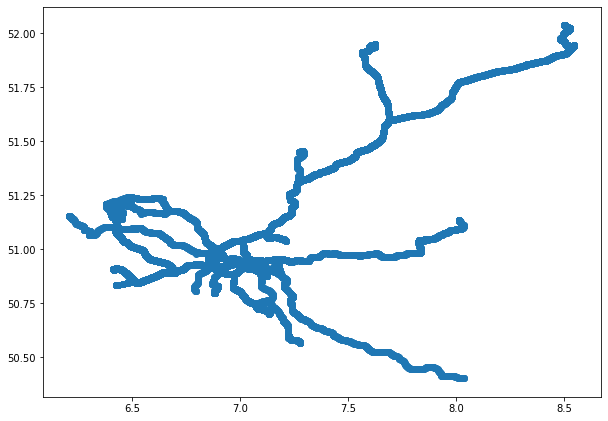

In [4]:
track_df.plot(figsize=(10, 12))

In [5]:
from pysal import esda
import numpy as np

from pyproj import CRS
from pyproj import Transformer

inputCRS = CRS.from_epsg(4326)
outputCRS = CRS.from_epsg(25832)
transformer = Transformer.from_crs(inputCRS, outputCRS)
def project(a,b):
    return transformer.transform(a, b)


## select stopping times data
df_speed = track_df[track_df['Speed.value'] == 0]

##group by geometry
## as the data is 5 sec if there are repeated lat,lng means the stop is +5 sec
df_speed['lat'] = df_speed['geometry'].apply(lambda coord: coord.y)
df_speed['lng'] = df_speed['geometry'].apply(lambda coord: coord.x)
df_speed['time_sec'] = 5
df_speed.reset_index()


data_speed = df_speed.groupby(['lat','lng'])[['time_sec']].sum().reset_index()
print(data_speed.head())
#change this directory 
#data_speed.to_csv('/home/poshan/Desktop/MSc/FloatingCar/envirocar-py/examples/data.csv')


         lat       lng  time_sec
0  50.565778  7.277756         5
1  50.565802  7.277791         5
2  50.565802  7.277791         5
3  50.565802  7.277750        25
4  50.565802  7.277750         5


In [6]:
data_speed['time_sec'].describe()

count    858.000000
mean       8.554779
std       16.701719
min        5.000000
25%        5.000000
50%        5.000000
75%        5.000000
max      265.000000
Name: time_sec, dtype: float64

In [7]:
### calculate weights for getis ord
coords = [project(row['lat'], row['lng']) for index, row in data_speed.iterrows()]
w = pysal.weights.DistanceBand(coords, threshold= 50)
w
# coords

/opt/anaconda/lib/python3.7/site-packages/pysal/weights/weights.py:189: UserWarning: There are 40 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/opt/anaconda/lib/python3.7/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 69, 72, 73, 74, 75, 78, 81, 82, 83, 84, 85, 86, 110, 111, 112, 170, 171, 180, 196, 197, 402, 417, 431, 457, 615, 655, 656, 659, 665, 666, 669, 682, 726, 793, 798, 836, 841, 855, 856, 857
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


In [8]:
#getisOrdGlobal = esda.getisord.G(data_speed['time_sec'], w)
getisOrdLocal = esda.getisord.G_Local(data_speed['time_sec'], w, transform='B')
getisOrdLocal.Zs

/opt/anaconda/lib/python3.7/site-packages/pysal/esda/getisord.py:434: RuntimeWarning: invalid value encountered in true_divide
  self.Zs = (self.Gs - self.EGs) / np.sqrt(self.VGs)


array([ 2.59008910e-01,  2.59008910e-01,  2.59008910e-01, -4.73165046e-02,
        2.59008910e-01,  2.59008910e-01,  2.59008910e-01,  1.05865387e-01,
        2.59008910e-01, -1.51987988e-01, -1.57110593e-01,  2.59008910e-01,
        2.59008910e-01,  1.82429915e-01,  1.82429915e-01,  2.59008910e-01,
       -4.26934951e-01, -4.26934951e-01, -4.26934951e-01, -4.26934951e-01,
       -4.26934951e-01, -2.13093080e-01, -2.13093080e-01, -3.01034337e-01,
       -8.97191116e-02, -8.97191116e-02, -1.41531161e+00, -1.41531161e+00,
       -1.41531161e+00, -1.41531161e+00, -1.41531161e+00, -1.41531161e+00,
       -1.41531161e+00, -1.41531161e+00, -1.41531161e+00, -1.41531161e+00,
       -1.41531161e+00, -1.41531161e+00, -1.41531161e+00, -1.41531161e+00,
       -1.41531161e+00, -1.41531161e+00, -1.41531161e+00, -1.41531161e+00,
       -1.41531161e+00, -1.41531161e+00, -1.41531161e+00, -1.41531161e+00,
       -1.41531161e+00, -1.41531161e+00, -1.41531161e+00, -1.41531161e+00,
       -1.41531161e+00, -

In [9]:
data_speed['z_score'] = getisOrdLocal.Zs
data_speed['p_value'] = getisOrdLocal.p_norm
# data_speed[data_speed['p_value'] < 0.05]
# data_speed[data_speed['z_score'] == 0]
# data_speed_hotspots = data_speed[data_speed['z_score'] > 0 and data_speed['p_value'] < 0.05]
# hotspots1 = data_speed[data_speed['p_value'] < 0.05]
#query
# hotspot = data_speed.query('z_score > 0 & p_value < 0.05')
#two conditions
hotspot = data_speed[(data_speed.z_score > 0) & (data_speed.p_value <=0.05)]
coldspot = data_speed[(data_speed.z_score < 0) & (data_speed.p_value <=0.05)]

hotspot

,lat,lng,time_sec,z_score,p_value
77,50.718685,7.118254,25,7.875772,1.665335e-15
79,50.719900,7.112676,40,1.888866,2.945492e-02
80,50.719964,7.112245,40,1.888866,2.945492e-02
87,50.726640,7.082341,55,2.242357,1.246916e-02
88,50.726732,7.082256,30,3.097380,9.761978e-04
89,50.726888,7.082131,40,2.281772,1.125140e-02
90,50.726937,7.082080,20,2.874825,2.021259e-03
102,50.727864,7.080958,40,1.714811,4.318999e-02
103,50.728270,7.080273,15,4.359674,6.512832e-06
104,50.728348,7.080116,85,3.490120,2.414022e-04


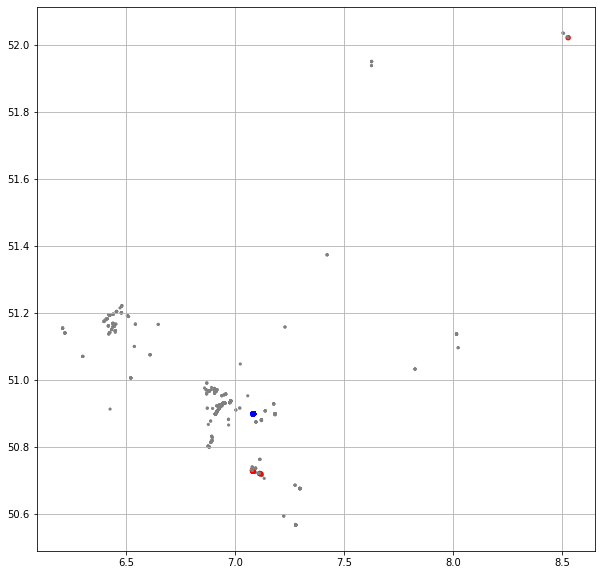

In [10]:
from matplotlib import pyplot as plt
#>1.96 hot spots
#<-1.96 cold spots
from matplotlib import colors as cls

f, axarr = plt.subplots(1, figsize=(10,10))
total_range = cls.Normalize(vmin = - 1.96, vmax = 1.96)

def pltcolor(p_value, z_score, confidence):
    cols=[]
    size=[]
    for p, z in zip(p_value, z_score):
        if p < confidence:
            if z > 0:
                cols.append('red')
                size.append(30)
            else:
                cols.append('blue')
                size.append(30)
        else:
            cols.append('grey')
            size.append(10)
    return cols , size


# Create the colors list using the function above
cols, sizes = pltcolor(data_speed['p_value'], data_speed['z_score'], 0.05)

plt.scatter(x=data_speed['lng'], y=data_speed['lat'], s=sizes, c=cols, lw = 0) #Pass on the list created by the function here
plt.grid(True)
plt.show()

In [11]:
import folium

lats = data_speed['lat']
lngs = data_speed['lng']

#z-value
z = data_speed['z_score']
p = data_speed['p_value']

avg_lat = sum(lats) / len(lats)
avg_lngs = sum(lngs) / len(lngs)

m = folium.Map(location=[avg_lat - 0.25, avg_lngs], tiles = 'Stamen Terrain', zoom_start=9)

color, sizes = pltcolor(p, z, 0.05)
time = data_speed['time_sec']
def makepopup(t):
    return str(t) + ' sec'

for lat,lng,c,s,t in zip(lats, lngs, color, sizes, time):
    radius = coords[2]
    folium.CircleMarker([lat,lng], color = c, radius = s, fill = c, popup = makepopup(t)).add_to(m)
m